![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb)

# 5 Text Classification with ClassifierDL

**Relevant blogpost:** https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32

## Colab Setup

In [ ]:
!wget https://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.2.1 -s 4.2.0 -g

In [1]:
#### INSTALLATION OF LIBRARIES FOR SPARK
!pip install findspark
!sudo apt update
!sudo apt install openjdk-17-jdk -y
!curl -JLO 'https://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz'
!tar xvf spark-3.3.1-bin-hadoop3.tgz
!mv spark-3.3.1-bin-hadoop3 /opt/spark
!pip install pyspark

Get:1 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]     
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]m
Get:5 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Get:6 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]0m
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [965 kB]m
Get:9 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2312 kB]33m
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1712 kB]
Get:13 http://archive.ubunt

In [3]:
!pip install sparknlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.6/648.6 kB 49.5 MB/s eta 0:00:00


In [4]:
import sparknlp

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
import os

spark = sparknlp.start(gpu = True)# for GPU training >> sparknlp.start(gpu = True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ddbe9f51-c515-4f81-bbb4-2e9b460e97fa;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;4.2.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.

22/11/21 01:07:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark NLP version 4.2.3
Apache Spark version: 3.3.1


<b><h1><font color='darkred'>!!! WARNING !!! </font><h1><b>



**If you get an error related to Java port not found 55, it is probably because that the Colab memory cannot handle the model and the Spark session died. In that case, try on a larger machine or restart the kernel at the top and then come back here and rerun.**

## ClassiferDL with Word Embeddings and Text Preprocessing

### Load Dataset

In [5]:
!pip install gdown
!mkdir data
!cd data
!gdown 1QhtF1UAbVMJyAcqVJDucYwmib0hHCP1A
!mv 'Dataset Yelp.zip' data.zip
!unzip data.zip
!mv  -v /notebooks/data/Dataset\ Yelp/* /notebooks/data/
!rm -rf /notebooks/data/Dataset\ Yelp

In [70]:
#### SPARK
import findspark
findspark.init()
from pyspark.sql import SparkSession
#import pyspark.pandas as ps

spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.3")\
    .getOrCreate()

spark.sparkContext.setLogLevel("OFF")

In [78]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [71]:
trainDataset = spark.read \
      .option("header", True) \
      .json("./data/review.json")

trainDataset = trainDataset.select("text","stars")
trainDataset.show(truncate=10)

+----------+-----+
|      text|stars|
+----------+-----+
|If you ...|  3.0|
|I've ta...|  5.0|
|Family ...|  3.0|
|Wow!  Y...|  5.0|
|Cute in...|  4.0|
|I am a ...|  1.0|
|Loved t...|  5.0|
|Amazing...|  5.0|
|This ea...|  3.0|
|Had a p...|  3.0|
|My expe...|  5.0|
|Locals ...|  4.0|
|Love go...|  4.0|
|Good fo...|  4.0|
|The bun...|  4.0|
|Great p...|  5.0|
|Tremend...|  5.0|
|The hub...|  4.0|
|I go to...|  5.0|
|My abso...|  5.0|
+----------+-----+
only showing top 20 rows



In [72]:
(trainingData, old) = trainDataset.randomSplit([0.005,0.995], seed = 100)

In [73]:
trainingData.count()

34613

In [74]:
from pyspark.sql.functions import col

trainingData.groupBy("stars") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-----+-----+
|stars|count|
+-----+-----+
|  5.0|15865|
|  4.0| 7425|
|  1.0| 5175|
|  3.0| 3459|
|  2.0| 2689|
+-----+-----+



In [75]:
(trainingData, testData) = trainingData.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 24214
Test Dataset Count: 10399


In [76]:
document_assembler = DocumentAssembler() \
            .setInputCol("text") \
            .setOutputCol("document")
    
tokenizer = Tokenizer() \
            .setInputCols(["document"]) \
            .setOutputCol("token")
          
normalizer = Normalizer() \
            .setInputCols(["token"]) \
            .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
            .setInputCols("normalized")\
            .setOutputCol("cleanTokens")\
            .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
            .setInputCols(["cleanTokens"]) \
            .setOutputCol("lemma")


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


### with Glove 100d embeddings

In [77]:
glove_embeddings = WordEmbeddingsModel().pretrained() \
                        .setInputCols(["document",'lemma'])\
                        .setOutputCol("embeddings")\
                        .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
                        .setInputCols(["document", "embeddings"]) \
                        .setOutputCol("sentence_embeddings") \
                        .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
                        .setInputCols(["sentence_embeddings"])\
                        .setOutputCol("class")\
                        .setLabelColumn("stars")\
                        .setMaxEpochs(3)\
                        .setEnableOutputLogs(True)
                        #.setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[
        document_assembler, 
        tokenizer,
        normalizer,
        stopwords_cleaner, 
        lemma, 
        glove_embeddings,
        embeddingsSentence,
        classsifierdl])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
'''
default classifierDL params:

    maxEpochs -> 10,
    lr -> 5e-3f,
    dropout -> 0.5f,
    batchSize -> 64,
    enableOutputLogs -> false,
    verbose -> Verbose.Silent.id,
    validationSplit -> 0.0f,
    outputLogsPath -> ""
    
'''

In [79]:
# Train (3 min for 3 epochs)
#%%time

clf_pipelineModel = clf_pipeline.fit(trainingData)

2022-11-21 02:40:49.534554: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/95120b379c12_classifier_dl14222982628749806573
2022-11-21 02:40:49.607412: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-11-21 02:40:49.607503: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/95120b379c12_classifier_dl14222982628749806573
2022-11-21 02:40:49.607751: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:40:49.609002: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 

Training started - epochs: 3 - learning_rate: 0.005 - batch_size: 64 - training_examples: 24214 - classes: 5
Epoch 1/3 - 1.15s - loss: 537.6626 - acc: 0.4573037 - batches: 379
Epoch 2/3 - 0.80s - loss: 537.9339 - acc: 0.4584611 - batches: 379
Epoch 3/3 - 0.89s - loss: 537.9339 - acc: 0.4584611 - batches: 379


In [80]:
import os
log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

Training started - epochs: 3 - learning_rate: 0.005 - batch_size: 64 - training_examples: 24214 - classes: 5
Epoch 0/3 - 1.92s - loss: 558.6931 - acc: 0.45723227 - batches: 379
Epoch 1/3 - 0.84s - loss: 558.934 - acc: 0.45822436 - batches: 379
Epoch 2/3 - 0.78s - loss: 558.934 - acc: 0.45822436 - batches: 379



In [81]:
# get the predictions on test Set
preds = clf_pipelineModel.transform(testData)

In [82]:
preds.select('stars','text',"class.result").show(40, truncate=80)

2022-11-21 02:41:04.743175: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:41:04.745823: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:41:04.748343: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:41:04.749580: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:41:04.7507

+-----+--------------------------------------------------------------------------------+------+
|stars|                                                                            text|result|
+-----+--------------------------------------------------------------------------------+------+
|  5.0|2/24/2017 First time here and to start off I can say that this won't be my la...| [5.0]|
|  4.0|A little hard to find, but I found the sushi to be good. I recommend the Hung...| [5.0]|
|  5.0|A perfect definition of southern hospitality and hidden gem. Went to the neig...| [5.0]|
|  5.0|A treasure in the wasteland of north Philly. An oasis of really good food.\nT...| [5.0]|
|  5.0|A trip to St Louis would not be complete without a stop to Ted Drewe's Frozen...| [5.0]|
|  5.0|Absolutely LOVE their selection of tomato pie.  My favorite is the roasted re...| [5.0]|
|  5.0|          Absolutely amazing and unique food. Love their bobba and pork pancake!| [5.0]|
|  4.0|After a long day, I got back to m

In [83]:
preds_df = preds.select('stars','text',"class.result").toPandas()

# The result is an array since in Spark NLP you can have multiple sentences.
# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])


In [84]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

print (classification_report(preds_df['stars'],preds_df['result'].astype(float)))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      1615
         2.0       0.00      0.00      0.00       804
         3.0       0.00      0.00      0.00       993
         4.0       0.00      0.00      0.00      2194
         5.0       0.46      1.00      0.63      4793

    accuracy                           0.46     10399
   macro avg       0.09      0.20      0.13     10399
weighted avg       0.21      0.46      0.29     10399



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### with Bert Embeddings

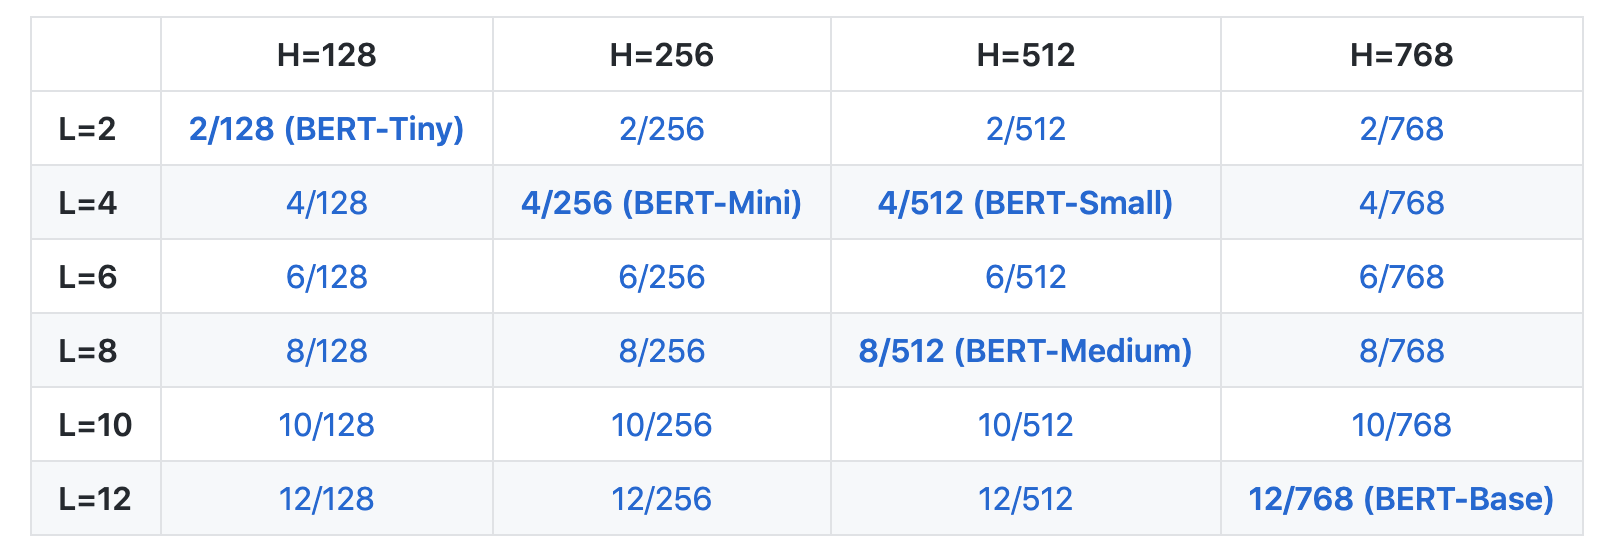

In [85]:
document_assembler = DocumentAssembler() \
                .setInputCol("text") \
                .setOutputCol("document")

tokenizer = Tokenizer() \
                .setInputCols(["document"]) \
                .setOutputCol("token")
      
bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
                .setInputCols(["document",'token'])\
                .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
                .setInputCols(["document", "embeddings"]) \
                .setOutputCol("sentence_embeddings") \
                .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
                .setInputCols(["sentence_embeddings"])\
                .setOutputCol("class")\
                .setLabelColumn("stars")\
                .setMaxEpochs(10)\
                .setLr(0.001)\
                .setBatchSize(8)\
                .setEnableOutputLogs(True)
                #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(stages=[document_assembler,
                                    tokenizer,
                                    bert_embeddings,
                                    embeddingsSentence,
                                    classsifierdl])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[ | ]small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
Download done! Loading the resource.
[ / ]

2022-11-21 02:42:33.918198: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:42:33.921203: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:42:33.924977: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:42:33.927930: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:42:33.9290

[OK!]


In [86]:
# remove the existing logs

! rm -r /root/annotator_logs

In [87]:
# training will take some time due to Bert (use GPU runtime when possible)

#%%time

bert_clf_pipelineModel = bert_clf_pipeline.fit(trainingData)

2022-11-21 02:44:15.058083: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/fd28093f08f5_classifier_dl17543511719340090878
2022-11-21 02:44:15.123989: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-11-21 02:44:15.124076: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/fd28093f08f5_classifier_dl17543511719340090878
2022-11-21 02:44:15.124308: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 02:44:15.125711: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 

Training started - epochs: 10 - learning_rate: 0.001 - batch_size: 8 - training_examples: 24214 - classes: 5
Epoch 1/10 - 5.68s - loss: 4028.8738 - acc: 0.56127447 - batches: 3027
Epoch 2/10 - 5.41s - loss: 3934.149 - acc: 0.5945005 - batches: 3027
Epoch 3/10 - 5.47s - loss: 3916.1812 - acc: 0.6022665 - batches: 3027
Epoch 4/10 - 5.36s - loss: 3902.3408 - acc: 0.607554 - batches: 3027
Epoch 5/10 - 5.29s - loss: 3892.5457 - acc: 0.6122632 - batches: 3027
Epoch 6/10 - 5.25s - loss: 3884.6594 - acc: 0.6151135 - batches: 3027
Epoch 7/10 - 5.46s - loss: 3877.579 - acc: 0.6166832 - batches: 3027
Epoch 8/10 - 5.45s - loss: 3871.5608 - acc: 0.6185421 - batches: 3027
Epoch 9/10 - 5.35s - loss: 3866.367 - acc: 0.619864 - batches: 3027
Epoch 10/10 - 5.26s - loss: 3861.8105 - acc: 0.6218055 - batches: 3027


In [ ]:
log_files = os.listdir("/root/annotator_logs")
log_files

['ClassifierDLApproach_6d2debf6acf3.log']

In [ ]:
log_file_name = os.listdir("/root/annotator_logs")[0]

with open("/root/annotator_logs/"+log_file_name, "r") as log_file :
    print(log_file.read())

Training started - epochs: 10 - learning_rate: 0.001 - batch_size: 8 - training_examples: 120000 - classes: 4
Epoch 0/10 - 26.58s - loss: 13310.637 - acc: 0.8557917 - batches: 15000
Epoch 1/10 - 26.01s - loss: 13093.017 - acc: 0.86985 - batches: 15000
Epoch 2/10 - 26.13s - loss: 12996.8955 - acc: 0.87644166 - batches: 15000
Epoch 3/10 - 26.04s - loss: 12921.24 - acc: 0.88136667 - batches: 15000
Epoch 4/10 - 26.12s - loss: 12868.196 - acc: 0.8853833 - batches: 15000
Epoch 5/10 - 27.37s - loss: 12825.866 - acc: 0.8887333 - batches: 15000
Epoch 6/10 - 26.54s - loss: 12790.789 - acc: 0.89110833 - batches: 15000
Epoch 7/10 - 26.60s - loss: 12757.739 - acc: 0.89359164 - batches: 15000
Epoch 8/10 - 27.41s - loss: 12729.906 - acc: 0.89565 - batches: 15000
Epoch 9/10 - 26.61s - loss: 12704.823 - acc: 0.8976667 - batches: 15000



In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

preds = bert_clf_pipelineModel.transform(testDataset)

preds_df = preds.select('category','description',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['category'], preds_df['result']))


              precision    recall  f1-score   support

    Business       0.83      0.83      0.83      1900
    Sci/Tech       0.83      0.86      0.85      1900
      Sports       0.93      0.96      0.95      1900
       World       0.91      0.86      0.88      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



## ClassifierDL with Universal Sentence Embeddings

In [ ]:
# actual content is inside description column
document = DocumentAssembler()\
                  .setInputCol("description")\
                  .setOutputCol("document")

# we can also use sentece detector here if we want to train on and get predictions for each sentence
use = UniversalSentenceEncoder.pretrained("tfhub_use_lg", "en") \
                  .setInputCols("document") \
                  .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
                  .setInputCols(["sentence_embeddings"])\
                  .setOutputCol("class")\
                  .setLabelColumn("category")\
                  .setMaxEpochs(3)\
                  .setLr(0.001)\
                  .setBatchSize(8)\
                  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(stages = [document,
                                      use,
                                      classsifierdl])

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[OK!]


In [ ]:
# remove the existing logs

! rm -r /root/annotator_logs

In [ ]:
%%time 
use_pipelineModel = use_clf_pipeline.fit(trainDataset)

CPU times: user 7.62 s, sys: 777 ms, total: 8.39 s
Wall time: 23min 30s


In [ ]:
log_files = os.listdir("/root/annotator_logs")
log_files

['ClassifierDLApproach_0d03c0f2bea8.log']

In [ ]:
with open("/root/annotator_logs/"+log_files[0], "r") as log_file :
    print(log_file.read())

Training started - epochs: 3 - learning_rate: 0.001 - batch_size: 8 - training_examples: 120000 - classes: 4
Epoch 0/3 - 26.41s - loss: 12745.125 - acc: 0.894025 - batches: 15000
Epoch 1/3 - 26.31s - loss: 12639.491 - acc: 0.90115833 - batches: 15000
Epoch 2/3 - 26.16s - loss: 12590.178 - acc: 0.9047167 - batches: 15000



### with BertSentenceEmbeddings

#### `sent_small_bert_L8_512` Model

In [ ]:
# actual content is inside description column
document = DocumentAssembler()\
              .setInputCol("description")\
              .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
              .setInputCols(["sentence_embeddings"])\
              .setOutputCol("class")\
              .setLabelColumn("category")\
              .setMaxEpochs(10)\
              .setEnableOutputLogs(True)\
              .setLr(0.001)

bert_sent_clf_pipeline = Pipeline(stages = [document,
                                            bert_sent,
                                            classsifierdl])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
# remove the existing logs

! rm -r /root/annotator_logs

In [ ]:
%%time
bert_sent_pipelineModel = bert_sent_clf_pipeline.fit(trainDataset)

CPU times: user 2.38 s, sys: 235 ms, total: 2.62 s
Wall time: 7min 31s


In [ ]:
from sklearn.metrics import classification_report

preds = bert_sent_pipelineModel.transform(testDataset)

preds_df = preds.select('category','description',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['category'], preds_df['result']))


              precision    recall  f1-score   support

    Business       0.83      0.86      0.85      1900
    Sci/Tech       0.86      0.87      0.86      1900
      Sports       0.95      0.97      0.96      1900
       World       0.92      0.86      0.89      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



In [ ]:
log_files = os.listdir("/root/annotator_logs")

with open("/root/annotator_logs/"+log_files[0], "r") as log_file :
    print(log_file.read())

Training started - epochs: 10 - learning_rate: 0.001 - batch_size: 64 - training_examples: 120000 - classes: 4
Epoch 0/10 - 4.17s - loss: 1644.6204 - acc: 0.8766583 - batches: 1875
Epoch 1/10 - 3.84s - loss: 1617.3008 - acc: 0.8876333 - batches: 1875
Epoch 2/10 - 3.82s - loss: 1609.8307 - acc: 0.89154166 - batches: 1875
Epoch 3/10 - 3.88s - loss: 1605.01 - acc: 0.8944167 - batches: 1875
Epoch 4/10 - 4.00s - loss: 1602.1359 - acc: 0.8964083 - batches: 1875
Epoch 5/10 - 3.81s - loss: 1599.8671 - acc: 0.8979667 - batches: 1875
Epoch 6/10 - 3.79s - loss: 1597.9937 - acc: 0.89926666 - batches: 1875
Epoch 7/10 - 3.86s - loss: 1596.2888 - acc: 0.90065 - batches: 1875
Epoch 8/10 - 3.89s - loss: 1594.6711 - acc: 0.9016167 - batches: 1875
Epoch 9/10 - 3.84s - loss: 1593.0895 - acc: 0.90251666 - batches: 1875



#### `sent_bert_use_cmlm_en_base` Model

In [ ]:
document = DocumentAssembler()\
              .setInputCol("description")\
              .setOutputCol("document")
    
bert_cmlm = BertSentenceEmbeddings.pretrained('sent_bert_use_cmlm_en_base', 'en')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

classsifierdl = ClassifierDLApproach()\
              .setInputCols(["sentence_embeddings"])\
              .setOutputCol("class")\
              .setLabelColumn("category")\
              .setMaxEpochs(10)\
              .setEnableOutputLogs(True)\
              .setLr(0.001)

bert_cmlm_clf_pipeline = Pipeline(stages = [document,
                                            bert_cmlm,
                                            classsifierdl])

sent_bert_use_cmlm_en_base download started this may take some time.
Approximate size to download 391.6 MB
[OK!]


In [ ]:
! rm -r /root/annotator_logs

In [ ]:
%%time
bert_cmlm_pipelineModel = bert_cmlm_clf_pipeline.fit(trainDataset)

CPU times: user 4.01 s, sys: 349 ms, total: 4.36 s
Wall time: 19min 24s


In [ ]:
from sklearn.metrics import classification_report

preds = bert_cmlm_pipelineModel.transform(testDataset)

preds_df = preds.select('category','description',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['category'], preds_df['result']))


              precision    recall  f1-score   support

    Business       0.88      0.86      0.87      1900
    Sci/Tech       0.86      0.91      0.88      1900
      Sports       0.96      0.98      0.97      1900
       World       0.94      0.88      0.91      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [ ]:
log_files = os.listdir("/root/annotator_logs")

with open("/root/annotator_logs/"+log_files[0], "r") as log_file :
    print(log_file.read())

Training started - epochs: 10 - learning_rate: 0.001 - batch_size: 64 - training_examples: 120000 - classes: 4
Epoch 0/10 - 4.10s - loss: 1593.4993 - acc: 0.893625 - batches: 1875
Epoch 1/10 - 3.76s - loss: 1562.1233 - acc: 0.9098167 - batches: 1875
Epoch 2/10 - 3.84s - loss: 1556.5115 - acc: 0.91335 - batches: 1875
Epoch 3/10 - 3.91s - loss: 1553.4943 - acc: 0.91618335 - batches: 1875
Epoch 4/10 - 3.99s - loss: 1550.9944 - acc: 0.91805834 - batches: 1875
Epoch 5/10 - 3.92s - loss: 1548.7216 - acc: 0.91949165 - batches: 1875
Epoch 6/10 - 3.78s - loss: 1546.771 - acc: 0.92075 - batches: 1875
Epoch 7/10 - 3.84s - loss: 1545.0651 - acc: 0.92141664 - batches: 1875
Epoch 8/10 - 3.79s - loss: 1543.5436 - acc: 0.922125 - batches: 1875
Epoch 9/10 - 3.87s - loss: 1542.1487 - acc: 0.922875 - batches: 1875



## Getting prediction from Trained model

In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(bert_cmlm_pipelineModel)

In [ ]:
testDataset.select('description').take(2)

[Row(description="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(description=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.')]

In [ ]:
text='''
Fearing the fate of Italy, the centre-right government has threatened to be merciless with those who flout tough restrictions. 
As of Wednesday it will also include all shops being closed across Greece, with the exception of supermarkets. Banks, pharmacies, pet-stores, mobile phone stores, opticians, bakers, mini-markets, couriers and food delivery outlets are among the few that will also be allowed to remain open.
'''
result = light_model.annotate(text)

result['class']

['World']

In [ ]:
light_model.annotate('the soccer games will be postponed.')

{'document': ['the soccer games will be postponed.'],
 'sentence_embeddings': ['the soccer games will be postponed.'],
 'class': ['Sports']}

# SentimentDL Classifier

see also here >> `https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/training/english/classification/SentimentDL_train_multiclass_sentiment_classifier.ipynb`

In [ ]:
!wget -q aclimdb_train.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_train.csv
!wget -q aclimdb_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_test.csv

In [ ]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("aclimdb_train.csv")

trainDataset.show(truncate=30)

+------------------------------+--------+
|                          text|   label|
+------------------------------+--------+
|This is an Excellent little...|positive|
|The Sarah Silverman program...|positive|
|"Prom Night" is a title-onl...|negative|
|So often a band will get to...|positive|
|"Pet Sematary" is an adapta...|positive|
|I watched the film recently...|negative|
|Boy this movie had me foole...|negative|
|Checking the spoiler alert ...|negative|
|Despite its rather salaciou...|positive|
|Absolute masterpiece of a f...|positive|
|The tweedy professor-types ...|positive|
|A movie best summed up by t...|negative|
|Take young, pretty people, ...|negative|
|For months I've been hearin...|negative|
|"Batman: The Mystery of the...|positive|
|Well, it was funny in spots...|negative|
|I have seen the short movie...|positive|
|Brainless film about a good...|negative|
|Leave it to geniuses like V...|negative|
|Seven Pounds stars Will Smi...|positive|
+------------------------------+--

In [ ]:
testDataset = spark.read \
      .option("header", True) \
      .csv("aclimdb_test.csv")

testDataset.show(truncate = 30)

+------------------------------+--------+
|                          text|   label|
+------------------------------+--------+
|The Second Woman is about t...|negative|
|In my opinion the directing...|positive|
|I am listening to Istanbul,...|positive|
|Before I speak my piece, I ...|negative|
|ManBearPig is a pretty funn...|positive|
|A buddy and I went to see t...|negative|
|It is incredible that there...|negative|
|Dire! Dismal! Awful! Laugha...|negative|
|HLOTS was an outstanding se...|positive|
|This is just one of those f...|negative|
|This movie had the potentia...|negative|
|The 80s were overrun by all...|positive|
|The tunes are the best aspe...|positive|
|Having recently seen Grindh...|positive|
|My favorite film this year....|positive|
|This movie just might make ...|positive|
|This is the worst movie I h...|negative|
|This was a nice film. It ha...|positive|
|I don't know, maybe I just ...|negative|
|After wasting 2 hours of my...|negative|
+------------------------------+--

In [ ]:
# actual content is inside description column
document = DocumentAssembler()\
            .setInputCol("text")\
            .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained("tfhub_use_lg", "en") \
            .setInputCols("document") \
            .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
sentimentdl = SentimentDLApproach()\
            .setInputCols(["sentence_embeddings"])\
            .setOutputCol("class")\
            .setLabelColumn("label")\
            .setMaxEpochs(5)\
            .setEnableOutputLogs(True)

pipeline = Pipeline(stages = [document,
                              use,
                              sentimentdl])

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[OK!]


In [ ]:
%%time
pipelineModel = pipeline.fit(trainDataset)

CPU times: user 768 ms, sys: 57.4 ms, total: 826 ms
Wall time: 4min 42s


In [ ]:
result = pipelineModel.transform(testDataset)

In [ ]:
result_df = result.select('text','label',"class.result").toPandas()

In [ ]:
result_df.head(10)

,text,label,result
0,The Second Woman is about the story of a myste...,negative,[positive]
1,"In my opinion the directing, editing, lighting...",positive,[positive]
2,"I am listening to Istanbul, intent, my eyes cl...",positive,[positive]
3,"Before I speak my piece, I would like to make ...",negative,[positive]
4,ManBearPig is a pretty funny episode of South ...,positive,[positive]
5,A buddy and I went to see this movie when it c...,negative,[negative]
6,It is incredible that there were two films wit...,negative,[negative]
7,Dire! Dismal! Awful! Laughable! Disappointing!...,negative,[negative]
8,"HLOTS was an outstanding series, its what NYPD...",positive,[positive]
9,This is just one of those films which cannot j...,negative,[negative]


# MultiLabel Classifier

see also here >> `https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/training/english/classification/MultiClassifierDL_train_multi_label_toxic_classifier.ipynb`

In [ ]:
!curl -O 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/toxic_comments/toxic_train.snappy.parquet'
!curl -O 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/toxic_comments/toxic_test.snappy.parquet'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2702k  100 2702k    0     0  1022k      0  0:00:02  0:00:02 --:--:-- 1022k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  289k  100  289k    0     0   147k      0  0:00:01  0:00:01 --:--:--  147k


In [ ]:
trainDataset = spark.read.parquet("./toxic_train.snappy.parquet").repartition(120)
testDataset = spark.read.parquet("./toxic_test.snappy.parquet").repartition(10)

## Multilabel Classifier with Bert Embeddings

In [ ]:
# Let's use shrink to remove new lines in the comments
document = DocumentAssembler()\
              .setInputCol("text")\
              .setOutputCol("document")\
              .setCleanupMode("shrink")

bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

# We will use MultiClassifierDL built by using Bidirectional GRU and CNNs inside TensorFlow that supports up to 100 classes
# We will use only 5 Epochs but feel free to increase it on your own dataset

multiClassifier = MultiClassifierDLApproach()\
              .setInputCols("sentence_embeddings")\
              .setOutputCol("category")\
              .setLabelColumn("labels")\
              .setBatchSize(128)\
              .setMaxEpochs(5)\
              .setLr(1e-3)\
              .setThreshold(0.5)\
              .setShufflePerEpoch(False)\
              .setEnableOutputLogs(True)\
              .setValidationSplit(0.1)

pipeline = Pipeline(stages = [document,
                              bert_sent,
                              multiClassifier])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
#! rm -r /root/annotator_logs

In [ ]:
%%time
pipelineModel = pipeline.fit(trainDataset)

CPU times: user 354 ms, sys: 25.9 ms, total: 380 ms
Wall time: 2min 6s


In [ ]:
!cat ~/annotator_logs/{multiClassifier.uid}.log

Training started - epochs: 5 - learning_rate: 0.001 - batch_size: 128 - training_examples: 13158 - classes: 6
Epoch 0/5 - 9.39s - loss: 0.33723184 - acc: 0.8611509 - batches: 103
Quality on validation dataset (10.0%), validation examples = 1462 
Epoch 1/5 - 0.95s - loss: 0.29930413 - acc: 0.8785859 - batches: 103
Quality on validation dataset (10.0%), validation examples = 1462 
Epoch 2/5 - 0.91s - loss: 0.2917258 - acc: 0.8815477 - batches: 103
Quality on validation dataset (10.0%), validation examples = 1462 
Epoch 3/5 - 0.89s - loss: 0.2864562 - acc: 0.8833028 - batches: 103
Quality on validation dataset (10.0%), validation examples = 1462 
Epoch 4/5 - 0.90s - loss: 0.28217906 - acc: 0.88537127 - batches: 103
Quality on validation dataset (10.0%), validation examples = 1462 


In [ ]:
preds = pipelineModel.transform(testDataset)

In [ ]:
preds_df = preds.select('text','labels',"category.result").toPandas()

In [ ]:
preds_df.head(10)

,text,labels,result
0,Vegan \n\nWhat in the hell does all that junk ...,[toxic],"[toxic, obscene]"
1,Fight Club! F**k Yeeaaaaahh!!!,"[toxic, obscene]","[toxic, obscene]"
2,"""\n\n Little quick on the trigger, ain't'cha b...",[toxic],[toxic]
3,Your user page indicates you're a left-wing li...,"[toxic, obscene, insult]",[toxic]
4,""" See all the many Google links, titled"""" Wik...",[toxic],[toxic]
5,"""\n\n LOL \n\nLOL. Seriously, """"BryanFromPalat...",[toxic],"[toxic, obscene]"
6,is it because it is of my naked mum having sex...,"[toxic, severe_toxic, obscene, insult, identit...","[toxic, severe_toxic, insult, obscene]"
7,")\na cowards site, that must stop changing thi...","[toxic, obscene]",[toxic]
8,"blow me, criticism IS constructive. \n\nBlow m...","[toxic, obscene, insult]","[toxic, insult, obscene]"
9,On account of the project deciding to ignore h...,"[toxic, obscene, insult]",[toxic]


## Saving & loading back the trained model

In [ ]:
pipelineModel.stages

[DocumentAssembler_b5d673d3fa9d,
 BERT_SENTENCE_EMBEDDINGS_3608c0d843af,
 MultiClassifierDLModel_9d02141e09c9]

In [ ]:
# Save the Multilabel Classifier Model
pipelineModel.stages[2].write().overwrite().save('MultilabelClfBert')

In [ ]:
# Load back  saved Multilabel Classifier Model
MultilabelClfModel = MultiClassifierDLModel.load('MultilabelClfBert')

In [ ]:
# Generate prediction Pipeline with loaded Model 
ld_pipeline = Pipeline(stages=[document, bert_sent, MultilabelClfModel])
ld_pipeline_model = ld_pipeline.fit(spark.createDataFrame([['']]).toDF("text"))

In [ ]:
# Apply Model Transform to testData
ld_preds = ld_pipeline_model.transform(testDataset)

In [ ]:
ld_preds_df = ld_preds.select('text','labels',"category.result").toPandas()


In [ ]:
ld_preds_df.head(10)

,text,labels,result
0,Vegan \n\nWhat in the hell does all that junk ...,[toxic],"[toxic, obscene]"
1,Fight Club! F**k Yeeaaaaahh!!!,"[toxic, obscene]","[toxic, obscene]"
2,"""\n\n Little quick on the trigger, ain't'cha b...",[toxic],[toxic]
3,Your user page indicates you're a left-wing li...,"[toxic, obscene, insult]",[toxic]
4,""" See all the many Google links, titled"""" Wik...",[toxic],[toxic]
5,"""\n\n LOL \n\nLOL. Seriously, """"BryanFromPalat...",[toxic],"[toxic, obscene]"
6,is it because it is of my naked mum having sex...,"[toxic, severe_toxic, obscene, insult, identit...","[toxic, severe_toxic, insult, obscene]"
7,")\na cowards site, that must stop changing thi...","[toxic, obscene]",[toxic]
8,"blow me, criticism IS constructive. \n\nBlow m...","[toxic, obscene, insult]","[toxic, insult, obscene]"
9,On account of the project deciding to ignore h...,"[toxic, obscene, insult]",[toxic]


# Case Study: Conference Title Classification 

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/title_conference.csv

In [ ]:
import pandas as pd

df = pd.read_csv('title_conference.csv')
df

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS
...,...,...
2502,A new QR-decomposition based recursive frequen...,ISCAS
2503,CNN Implementation of Spin Filters for Electro...,ISCAS
2504,FaceKit: A Database Interface Design Toolkit.,VLDB
2505,On the trade-off between the number of scrolls...,ISCAS


In [ ]:
df.Conference.value_counts()

ISCAS       864
INFOCOM     515
VLDB        423
WWW         379
SIGGRAPH    326
Name: Conference, dtype: int64

In [ ]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("title_conference.csv")

(trainingData, testData) = trainDataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))


Training Dataset Count: 2030
Test Dataset Count: 477


In [ ]:
document = DocumentAssembler()\
            .setInputCol("Title")\
            .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

use = UniversalSentenceEncoder.pretrained()\
            .setInputCols(["document"])\
            .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
            .setInputCols(["sentence_embeddings"])\
            .setOutputCol("class")\
            .setLabelColumn("Conference")\
            .setMaxEpochs(20)\
            .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(stages = [document,
                                      use,
                                      classsifierdl])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
%%time

use_pipelineModel = use_clf_pipeline.fit(trainingData)

# 20 epochs takes around 20 seconds !

In [ ]:
preds = use_pipelineModel.transform(testData)

preds.select('Title','Conference',"class.result").show(10, truncate=80)


+--------------------------------------------------------------------------------+----------+----------+
|                                                                           Title|Conference|    result|
+--------------------------------------------------------------------------------+----------+----------+
|                       "From ""Think Like a Vertex"" to ""Think Like a Graph""."|      VLDB|   [ISCAS]|
|                                                  1, 000 Tables Inside the From.|      VLDB|    [VLDB]|
|                             10Gbit/s 2mW inductorless transimpedance amplifier.|     ISCAS|   [ISCAS]|
|3D reconstruction from planar points: A candidate method for authentication o...|     ISCAS|[SIGGRAPH]|
|        7-decades tunable translinear SiGe BiCMOS 3-phase sinusoidal oscillator.|     ISCAS|   [ISCAS]|
|           A 0.18-&micro;m CMOS Squarer Circuit for a Non-Coherent UWB Receiver.|     ISCAS|   [ISCAS]|
|    A 10-Bit 200-MS/s digitally-calibrated pipelined A

In [ ]:
# We are going to use sklearn to evalute the results on test dataset
preds_df = preds.select('Conference','Title',"class.result").toPandas()

# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

from sklearn.metrics import classification_report

print (classification_report(preds_df['Conference'], preds_df['result']))


              precision    recall  f1-score   support

     INFOCOM       0.78      0.62      0.69        98
       ISCAS       0.82      0.85      0.83       177
    SIGGRAPH       0.66      0.73      0.69        51
        VLDB       0.57      0.72      0.64        69
         WWW       0.70      0.62      0.66        82

    accuracy                           0.73       477
   macro avg       0.71      0.71      0.70       477
weighted avg       0.74      0.73      0.73       477



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

preds = pd.DataFrame(confusion_matrix(preds_df['result'], preds_df['Conference']), columns = np.unique(preds_df['Conference']), index =  np.unique(preds_df['Conference']))
preds

,INFOCOM,ISCAS,SIGGRAPH,VLDB,WWW
INFOCOM,61,8,1,2,6
ISCAS,16,150,9,5,3
SIGGRAPH,1,9,37,3,6
VLDB,11,8,2,50,16
WWW,9,2,2,9,51


### Bert Sentence Embeddings

In [ ]:
document = DocumentAssembler()\
              .setInputCol("Title")\
              .setOutputCol("document")
    
bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
              .setInputCols(["sentence_embeddings"])\
              .setOutputCol("class")\
              .setLabelColumn("Conference")\
              .setMaxEpochs(20)\
              .setLr(0.001)\
              .setBatchSize(8)\
              .setEnableOutputLogs(True)

bert_clf_pipeline = Pipeline(stages = [document,
                                      bert_sent,
                                      classsifierdl])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
classsifierdl.getMaxEpochs()

20

In [ ]:
%%time
#20 epochs 30 secs !

bert_pipelineModel = bert_clf_pipeline.fit(trainingData)


CPU times: user 66.6 ms, sys: 9.02 ms, total: 75.6 ms
Wall time: 18.1 s


In [ ]:
from sklearn.metrics import classification_report

preds = bert_pipelineModel.transform(testData)

preds_df = preds.select('Conference',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['Conference'], preds_df['result']))


              precision    recall  f1-score   support

     INFOCOM       0.78      0.74      0.76        98
       ISCAS       0.84      0.90      0.87       177
    SIGGRAPH       0.66      0.65      0.65        51
        VLDB       0.59      0.62      0.61        69
         WWW       0.74      0.62      0.68        82

    accuracy                           0.75       477
   macro avg       0.72      0.71      0.71       477
weighted avg       0.75      0.75      0.75       477



# Save model and Zip it for Modelshub Upload/Downloads

In [ ]:
# Save a Spark NLP pipeline
bert_clf_pipeline.save('my_nlp_pipeline')

# cd into saved dir and zip
! cd ./my_nlp_pipeline ; zip -r my_nlp_pipeline.zip *

  adding: metadata/ (stored 0%)
  adding: metadata/.part-00000.crc (stored 0%)
  adding: metadata/._SUCCESS.crc (stored 0%)
  adding: metadata/_SUCCESS (stored 0%)
  adding: metadata/part-00000 (deflated 19%)
  adding: stages/ (stored 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/ (stored 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/.bert_sentence_tensorflow.crc (deflated 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/fields/ (stored 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/fields/vocabulary/ (stored 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/fields/vocabulary/.part-00002.crc (stored 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/fields/vocabulary/.part-00000.crc (stored 0%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/fields/vocabulary/part-00002 (deflated 78%)
  adding: stages/1_BERT_SENTENCE_EMBEDDINGS_3608c0d843af/fields/vocabulary/._SUCCESS.crc (stored 0%)
  adding: stages/